In [65]:
import pandas as pd
import numpy as np
import openpyxl
import xlsxwriter
import matplotlib.pyplot as plt
import seaborn as sns
import random
from operator import itemgetter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression

## Euros winners predictor

In [66]:
df = pd.read_excel('trainingData.xlsx')
 
df

,team,ranking,points,value,host,form,percentage
0,netherlands,10.0,1694.51,587.25,n,WWDWWW,62.0
1,usa,15.0,1627.48,277.40,n,WDWDLD,38.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN
4,argentina,4.0,1773.88,633.20,n,DWWWWW,75.0
...,...,...,...,...,...,...,...
225,luxembourg,87.0,1277.94,30.83,n,WLDLWW,22.0
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,57,NaN,NaN,NaN,NaN,NaN,NaN
228,england,4.0,1794.90,1470.00,y,WWLWLW,98.0


# create objects for the game and the teams

In [67]:
class Team():
    def __init__(self, name, ranking, points, value, host, form):
        self.name = name
        self.ranking = ranking
        self.points = points
        self.value = value
        self.host = host
        self.form = form
    
    def get_name(self):
        name_unstripped = self.name
        return name_unstripped.strip()
    
    def get_ranking(self):
        return self.ranking
    
    def get_points(self):
        return self.points
    
    def get_value(self):
        return self.value
    
    def get_host(self):
        return self.host
    
    # def get_formString(self):
    #     return self.form
    
    # def get_form(self):
    #     formString = self.get_formString()
    #     form_points = 0
    #     for element in formString:
    #         if element == 'W':
    #             form_points += 3
    #         elif element == 'D':  # Added missing colon here
    #             form_points += 1
    #     return form_points
    
    def get_form(self):
        return self.form
        
class Game():
    def __init__(self, team1, team2, percentage1):  # Added missing colon here
        self.team1 = team1
        self.team2 = team2
        self.percentage1 = percentage1
    
    def get_team1(self):
        return self.team1
    
    def get_team2(self):
        return self.team2
    
    def get_percentage1(self):
        return self.percentage1
    
    def get_ranking_diff(self):
        team1 = self.get_team1()
        team2 = self.get_team2()
        ranking1 = team1.get_ranking()
        ranking2 = team2.get_ranking()  
        return ranking1 - ranking2
    
    def get_points_diff(self):
        team1 = self.get_team1() 
        team2 = self.get_team2()  
        points1 = team1.get_points()  
        points2 = team2.get_points() 
        difference = points1 - points2
        return difference

    def get_value_diff(self):
        team1 = self.get_team1() 
        team2 = self.get_team2()  
        value1 = team1.get_value()
        value2 = team2.get_value()
        difference = value1 - value2
        total = value1 + value2
        return difference/total
    
    def is_home_game(self):
        team1 = self.get_team1() 
        if team1.get_host() == 'y':
            return 1
        else:
            return 0
    
    def get_form_diff(self):
        team1 = self.get_team1() 
        team2 = self.get_team2()  
        form1 = team1.get_form()
        form2 = team2.get_form()
        return form1 - form2
    
    def set_percentage1(self, percentage1):
        self.percentage1 = percentage1

create the objects of games and teams from the training data

In [68]:
# 2,3 6,7 10,11 14,15
# start at 2, index += 4, i and i + 1 are the teams, percentage at i is the percentage taken in for the game object
# add the games to a list of games

no_of_rows = len(df) # there are 62 rows in the dataframe
i = 0
games = []
while i < no_of_rows:
    # name 
    name1 = df.loc[i]["team"]
    name2 = df.loc[i+1]["team"]
    
    # ranking 
    ranking1 = df.loc[i]["ranking"]
    ranking2 = df.loc[i+1]["ranking"]

    # points 
    points1 = df.loc[i]["points"]
    points2 = df.loc[i+1]["points"]
    
    # value 
    value1 = df.loc[i]["value"]
    value2 = df.loc[i+1]["value"]
    
    # host 
    host1 = df.loc[i]["host"]
    host2 = df.loc[i+1]["host"]
    
    # form 
    formString1 = df.loc[i]["form"]
    formString2 = df.loc[i+1]["form"]
    form1 = 0
    for element in formString1:
            if element == 'W':
                form1 += 3
            elif element == 'D':
                form1 += 1
    form2 = 0
    for element in formString2:
            if element == 'W':
                form2 += 3
            elif element == 'D':
                form2 += 1
    
    print(name1,ranking1,points1,value1,host1,form1)
    print(name2,ranking2,points2,value2,host2,form2)
    # percentage
    percentage1 = df.loc[i]["percentage"]
    
    team1 = Team(name1,ranking1,points1,value1,host1,form1)
    team2 = Team(name2,ranking2,points2,value2,host2,form2)
    
    game = Game(team1,team2,percentage1)
    games.append(game)
    
    i += 4
    
# games is the list of sample games. 

netherlands  10.0 1694.51 587.25 n 16
usa 15.0 1627.48 277.4 n 9
argentina  4.0 1773.88 633.2 n 16
australia  38.0 1488.72 38.34 n 13
france 3.0 1759.78 1080.0 n 5
poland  26.0 1548.59 255.6 n 7
england  5.0 1728.47 1310.0 n 5
senegal 20.0 1584.38 229.5 n 13
japan  23.0 1559.54 154.0 n 11
croatia 16.0 1645.64 377.0 n 16
brazil 1.0 1841.3 1140.0 n 18
south korea 29.0 1530.3 164.48 n 13
morocco 24.0 1563.5 251.1 n 13
spain 7.0 1715.22 902.0 n 13
portugal 8.0 1676.56 937.0 n 12
switzerland 14.0 1635.92 281.0 n 9
croatia 16.0 1645.64 377.0 n 16
brazil 1.0 1841.3 1140.0 n 18
netherlands 10.0 1694.51 587.25 n 16
argentina  4.0 1773.88 633.2 n 16
morocco 24.0 1563.5 251.1 n 13
portugal 8.0 1676.56 937.0 n 12
england  5.0 1728.47 1310.0 n 5
france 3.0 1759.78 1080.0 n 5
argentina  4.0 1773.88 633.2 n 16
croatia 16.0 1645.64 377.0 n 16
france  3.0 1759.78 1080.0 n 5
morocco 24.0 1563.5 251.1 n 13
morocco 24.0 1563.5 251.1 n 13
croatia 16.0 1645.64 377.0 n 16
argentina  4.0 1773.88 633.2 n 16
fr

create a new dataframe using the getters from the games list.

In [69]:
# create a list of dictionaries of the games and their attributes
processedData = []

for game in games:
    ranking_diff = game.get_ranking_diff()
    points_diff = game.get_points_diff()
    value_diff = game.get_value_diff()
    host = game.is_home_game()
    form_diff = game.get_form_diff()
    percentage1 = game.get_percentage1()
    processedData.append({'rankingDiff' : ranking_diff, 'pointsDiff' : points_diff, 'valueDiff' : value_diff, 'host' : host, 'formDiff' : form_diff, 'percentage1' : percentage1})

# print(processedData)

processedDataFrame = pd.DataFrame(processedData)

processedDataFrame

,rankingDiff,pointsDiff,valueDiff,host,formDiff,percentage1
0,-5.0,67.03,0.358353,0,7,62.0
1,-34.0,285.16,0.885815,0,3,75.0
2,-23.0,211.19,0.617251,0,-2,67.0
3,-15.0,144.09,0.701851,0,-8,68.0
4,7.0,-86.10,-0.419962,0,-5,39.0
5,-28.0,311.00,0.747823,0,5,77.0
6,17.0,-151.72,-0.564478,0,0,32.0
7,-6.0,40.64,0.538588,0,3,70.0
8,15.0,-195.66,-0.502966,0,-2,27.0
9,6.0,-79.37,-0.037650,0,0,39.0


# creating the predictive model

Part 1: EDA

the dataset that we will use is processedDataFrame

size of the dataset:

In [70]:
print(processedDataFrame.shape)

(58, 6)


In [71]:
processedDataFrame.head()

,rankingDiff,pointsDiff,valueDiff,host,formDiff,percentage1
0,-5.0,67.03,0.358353,0,7,62.0
1,-34.0,285.16,0.885815,0,3,75.0
2,-23.0,211.19,0.617251,0,-2,67.0
3,-15.0,144.09,0.701851,0,-8,68.0
4,7.0,-86.10,-0.419962,0,-5,39.0


Bivariate analysis 

1. relationship between ranking difference and the winning probability

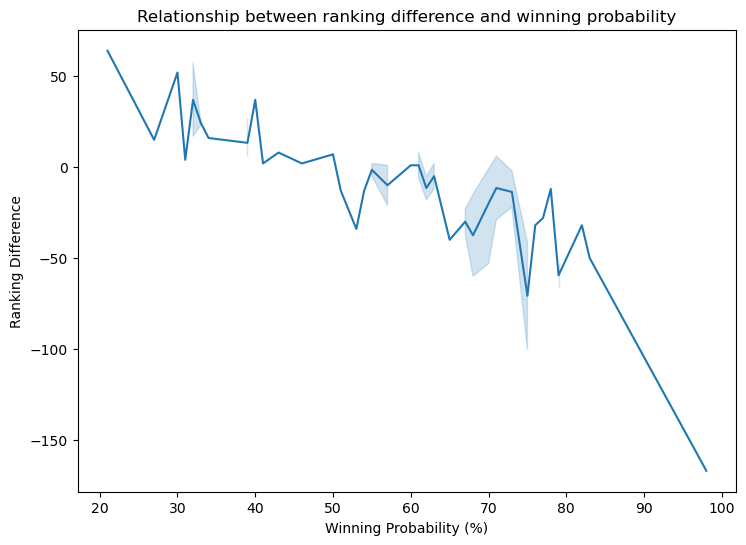

In [72]:
plt.figure(figsize=(8.5, 6))
plt.title('Relationship between ranking difference and winning probability')
sns.lineplot(x="percentage1", y="rankingDiff", data=processedDataFrame)
plt.xlabel('Winning Probability (%)')
plt.ylabel('Ranking Difference')
plt.show()

there is a negative relationship because the "stronger" team will be of a lower rank than the "weaker" team, and thus the percentage chance of it winning will be higher.

2. relationship between rank points difference and winning probabiltiy

ranking points is more accurate than rank but it shld still show similar results.

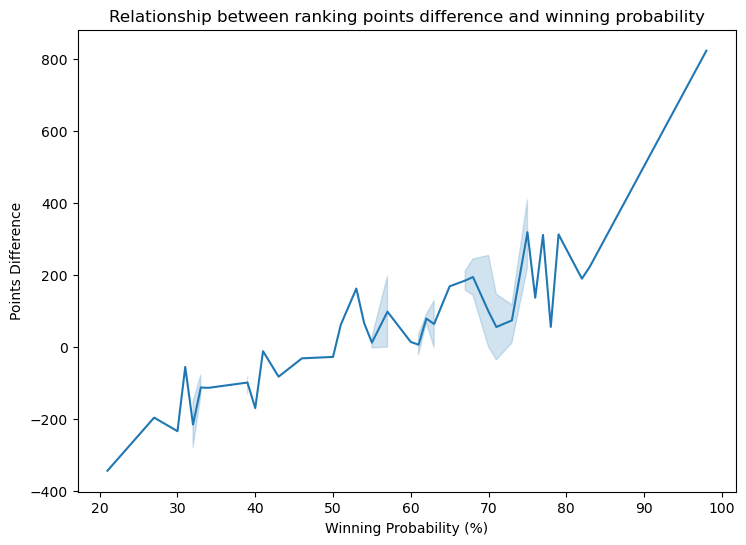

In [73]:
plt.figure(figsize=(8.5, 6))
plt.title('Relationship between ranking points difference and winning probability')
sns.lineplot(x="percentage1", y="pointsDiff", data=processedDataFrame)
plt.xlabel('Winning Probability (%)')
plt.ylabel('Points Difference')
plt.show()

this is a positive relationship because the "stronger" team will have higher points than the "weaker" team.

3. relationship between squad value difference and winning probailty

the value difference in the data is processed to be a ratio between the numerical difference and the value of the first team. This is to take into account squad values of all sizes. 

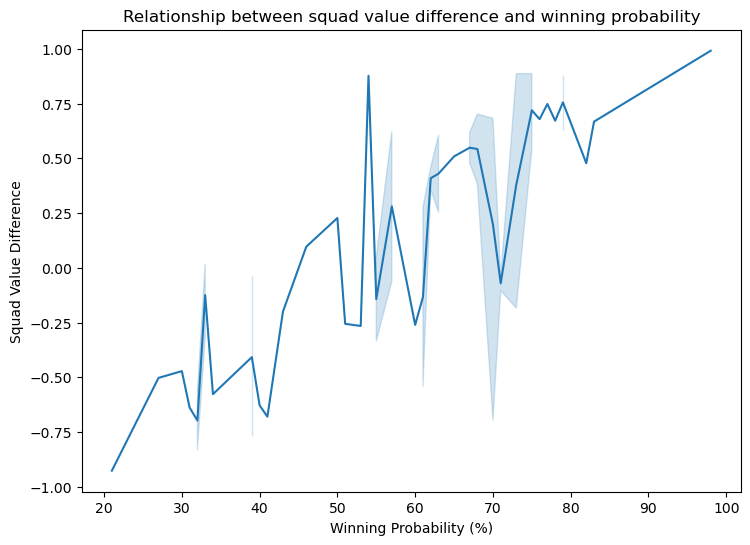

In [74]:
plt.figure(figsize=(8.5, 6))
plt.title('Relationship between squad value difference and winning probability')
sns.lineplot(x="percentage1", y="valueDiff", data=processedDataFrame)
plt.xlabel('Winning Probability (%)')
plt.ylabel('Squad Value Difference')
plt.show()

this shows that in general, a higher squad value translates to higher win probability

we wont show the relationship between host and winning probabilty becuase it is in essence categorical data

4. relationship between form and winning probabilty

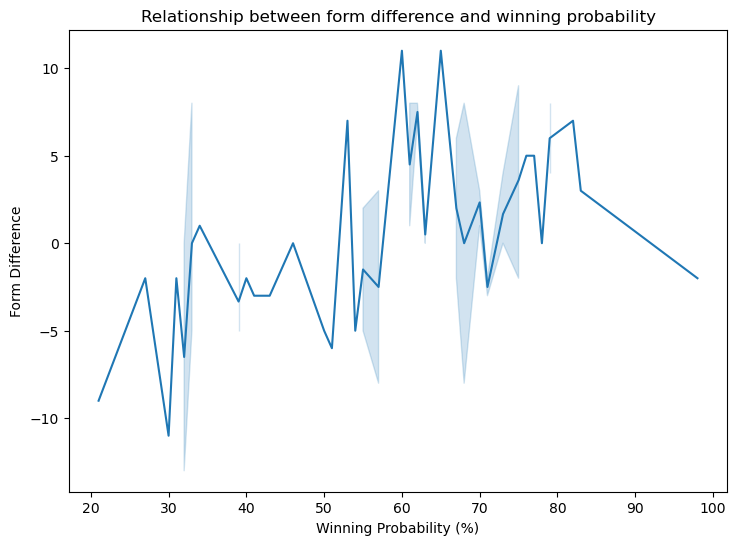

In [75]:
plt.figure(figsize=(8.5, 6))
plt.title('Relationship between form difference and winning probability')
sns.lineplot(x="percentage1", y="formDiff", data=processedDataFrame)
plt.xlabel('Winning Probability (%)')
plt.ylabel('Form Difference')
plt.show()

there is a fluctuating relationship between form and winning probabilty
this shows that in reality form doesnt rlly affect a team's winning chances. 
however, it is good to note that it tends to increase slightly

Part 2: Feature importance

regression model: to decide how each variable affects the winning probability

feature importance: see how important a variable is to determining winning probabilty

In [76]:
Feature_Impt_X = processedDataFrame.drop(['percentage1'],axis=1)
Feature_Impt_Y = processedDataFrame['percentage1']

In [77]:
Feature_Impt_X

,rankingDiff,pointsDiff,valueDiff,host,formDiff
0,-5.0,67.03,0.358353,0,7
1,-34.0,285.16,0.885815,0,3
2,-23.0,211.19,0.617251,0,-2
3,-15.0,144.09,0.701851,0,-8
4,7.0,-86.10,-0.419962,0,-5
5,-28.0,311.00,0.747823,0,5
6,17.0,-151.72,-0.564478,0,0
7,-6.0,40.64,0.538588,0,3
8,15.0,-195.66,-0.502966,0,-2
9,6.0,-79.37,-0.037650,0,0


In [78]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example: Add a scaler step
    ('RandomForestRegressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the pipeline
pipeline.fit(Feature_Impt_X, Feature_Impt_Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForestRegressor',
                 RandomForestRegressor(random_state=42))])

In [79]:
# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your feature matrix
Feature_Impt_X_imputed = imputer.fit_transform(Feature_Impt_X)

# Now, fit your pipeline with the imputed data
pipeline.fit(Feature_Impt_X_imputed, Feature_Impt_Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForestRegressor',
                 RandomForestRegressor(random_state=42))])

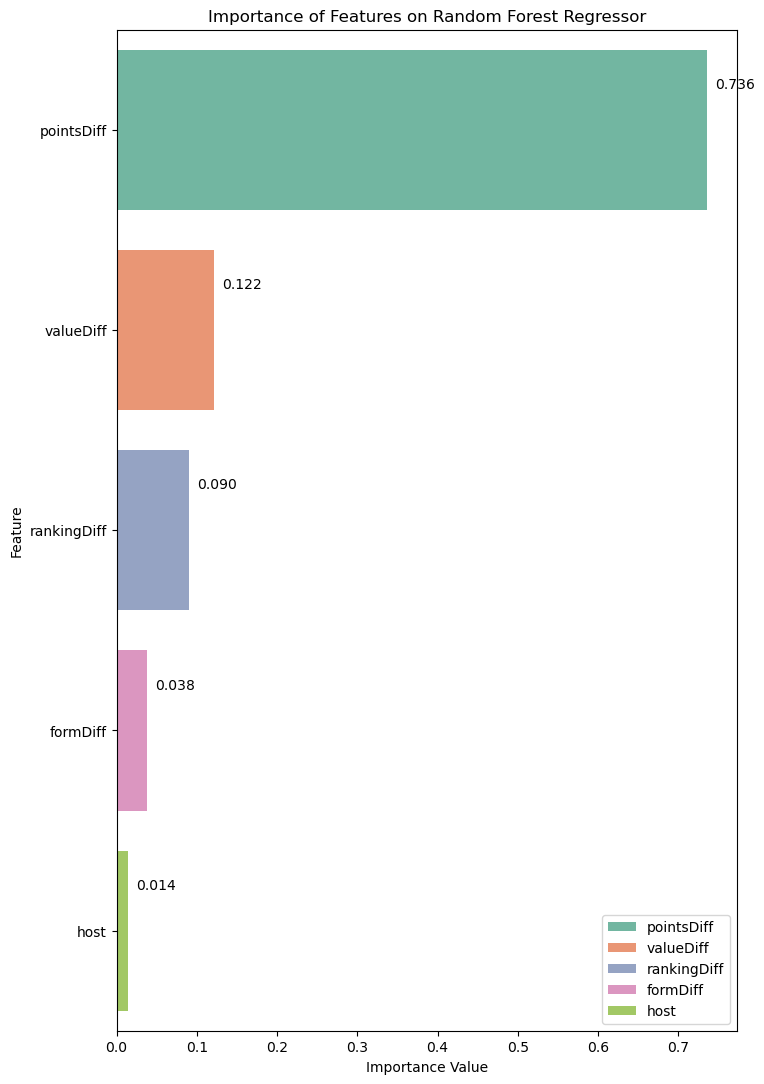

In [80]:
feature_importance = pd.Series(pipeline.named_steps['RandomForestRegressor'].feature_importances_, index=Feature_Impt_X.columns).sort_values(ascending=False)
fig = plt.figure(figsize=(8,13))
plot = sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=("Set2"), hue = feature_importance.index, dodge=False)
for p in plot.patches:
    plot.annotate(f"{p.get_width():.3f}",
                   (p.get_x() + p.get_width(), p.get_y()),
                   ha = 'center', va = 'center',
                   xytext = (20, -25),
                   textcoords = 'offset points')

plt.title('Importance of Features on Random Forest Regressor')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.show()

Using a correlation heatmap

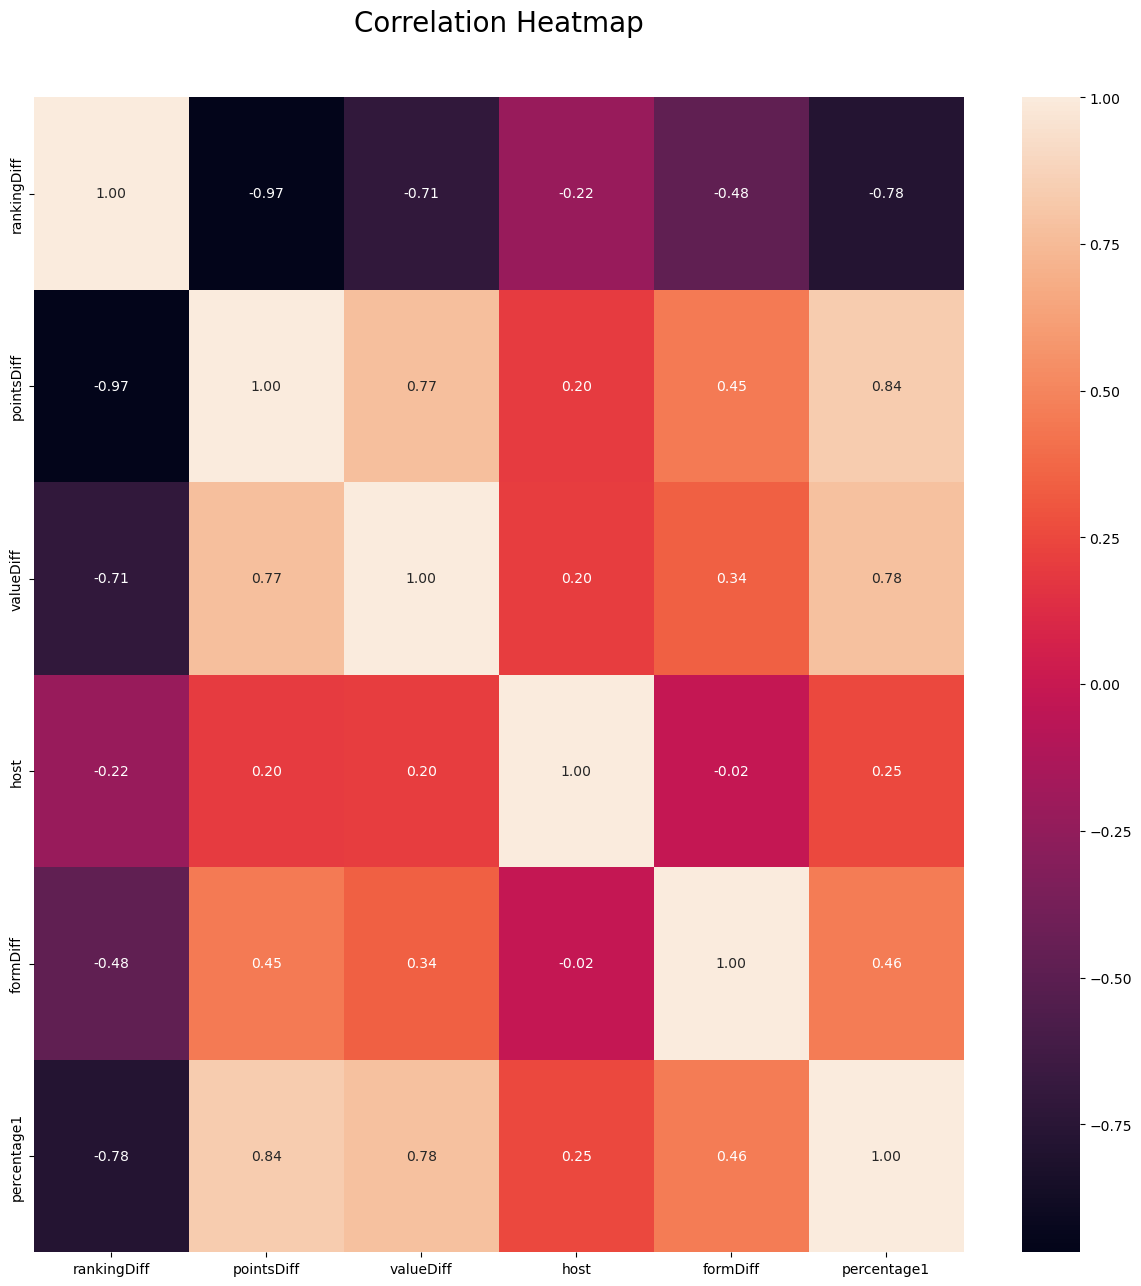

In [81]:
plt.figure(figsize=(15,15), facecolor='white')
sns.heatmap(processedDataFrame.corr(),annot=True,fmt='.2f')
plt.title("Correlation Heatmap", fontsize = 20, y=1.05)
plt.show()

The heatmap actually shows that in reality, the fact that the country is a host, it doesnt really affect the winning probability as compared to other features here.

They are ranked in importance as follows:
1. points difference
2. ranking difference
3. value difference 
4. form difference
5. host

Since all are relavant to a certain extent, we aren't going to drop any values

Part 3: Training the model

firstly we need to split the dataset into training and testing

80% of the data will be used as training data and 20% will be used for testing

In [82]:
X = processedDataFrame.drop(['percentage1'], axis=1)
y = processedDataFrame['percentage1']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=19)

we will be using the random forest regressor because it is known to be more accurate

In [84]:
rfr = RandomForestRegressor(random_state=13)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=13)

In [85]:
y_pred = rfr.predict(X_test)

In [86]:
mean_absolute_error(y_pred, y_test)

8.693333333333333

In [87]:
mean_squared_error(y_pred, y_test)

137.8759666666667

In [88]:
r2_score(y_pred, y_test)

0.40049111191879794

now lets try the ridge regression model

In [89]:
# trying different models
r = Ridge()
r.fit(X_train, y_train)

Ridge()

In [90]:
y_pred = r.predict(X_test)

In [91]:
mean_absolute_error(y_pred, y_test)

3.8720841585802237

In [92]:
mean_squared_error(y_pred, y_test)

33.662810526627474

In [93]:
r2_score(y_pred, y_test)

0.960285698431138

the ridge regressor model has a r2 value that is higher than the random regressor model and lower error, this may be because the dataset is small which may lead to problems when using the random forest regressor

now lets try the linear regression model

In [94]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred = model.predict(X_test)

In [96]:
mean_absolute_error(y_pred, y_test)

3.7696671443262555

In [97]:
mean_squared_error(y_pred, y_test)

30.104221577169636

In [98]:
r2_score(y_pred, y_test)

0.9637439870629454

the linear regression model actually has the best outcomes, so we shall use the linear regression model as the final model.

since we are using the linear model, we shall rename the model to 'model'

# Creating another dataset to input the values into the model

In [99]:
# testing the linear regression model 
team1 = Team("germany", 4, 1744.21, 1072, 'y', "WWWDLW")
team2 = Team("scotland", 39, 1497.46, 239.40, 'n', "LLDDLL")
game = Game(team1,team2, 0)
first = game.get_ranking_diff()
second = game.get_points_diff()
third = game.get_value_diff()
fourth = game.is_home_game()
# fifth = game.get_form_diff()

# Assuming X_input is your 1D input array
X_input = np.array([first, second, third, fourth, 11])  # Example input array

# Reshape the input array into a 2D array with a single row
X_input_reshaped = X_input.reshape(1, -1)

# Now, you can use the reshaped input array for prediction
predicted = model.predict(X_input_reshaped)
print(predicted)

[82.93666258]


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


the model works!

In [100]:
teamsdf = pd.read_excel('testingData.xlsx')
teamsdf

,team,ranking,points,value,host,form
0,Germany,16,1644.21,672.00,y,WWLLDW
1,Scotland,39,1497.46,239.40,n,LLDDLL
2,Hungary,26,1532.20,166.65,n,WWWDDW
3,Switzerland,19,1616.41,223.20,n,WDLDDD
4,Spain,8,1727.50,906.00,n,DLWWWW
5,Italy,9,1724.60,757.00,n,WWDWLW
6,Croatia,10,1721.07,286.00,n,WDWWLL
7,Albania,66,1375.10,123.05,n,LLDDWW
8,Slovenia,57,1427.84,130.85,n,WDWLWW
9,Denmark,21,1602.72,368.50,n,WDLWWW


create groups

In [101]:
groups = []
no_of_rows = len(teamsdf)
i = 0
while i < no_of_rows:
    group = []
    # name 
    name1 = teamsdf.loc[i]["team"]
    name2 = teamsdf.loc[i+1]["team"]
    name3 = teamsdf.loc[i+2]["team"]
    name4 = teamsdf.loc[i+3]["team"]
    
    # ranking 
    ranking1 = teamsdf.loc[i]["ranking"]
    ranking2 = teamsdf.loc[i+1]["ranking"]
    ranking3 = teamsdf.loc[i+2]["ranking"]
    ranking4 = teamsdf.loc[i+3]["ranking"]

    # points 
    points1 = teamsdf.loc[i]["points"]
    points2 = teamsdf.loc[i+1]["points"]
    points3 = teamsdf.loc[i+2]["points"]
    points4 = teamsdf.loc[i+3]["points"]
    
    # value 
    value1 = teamsdf.loc[i]["value"]
    value2 = teamsdf.loc[i+1]["value"]
    value3 = teamsdf.loc[i+2]["value"]
    value4 = teamsdf.loc[i+3]["value"]

    # host 
    host1 = teamsdf.loc[i]["host"]
    host2 = teamsdf.loc[i+1]["host"]
    host3 = teamsdf.loc[i+2]["host"]
    host4 = teamsdf.loc[i+3]["host"]
    
    # form 
    formString1 = teamsdf.loc[i]["form"]
    formString2 = teamsdf.loc[i+1]["form"]
    formString3 = teamsdf.loc[i+2]["form"]
    formString4 = teamsdf.loc[i+3]["form"]
    form1 = 0
    for element in formString1:
            if element == 'W':
                form1 += 3
            elif element == 'D':
                form1 += 1
    form2 = 0
    for element in formString2:
            if element == 'W':
                form2 += 3
            elif element == 'D':
                form2 += 1
    form3 = 0
    for element in formString3:
            if element == 'W':
                form3 += 3
            elif element == 'D':
                form3 += 1
    form4 = 0
    for element in formString4:
            if element == 'W':
                form4 += 3
            elif element == 'D':
                form4 += 1
    
    print(name1,ranking1,points1,value1,host1,form1)
    print(name2,ranking2,points2,value2,host2,form2)
    print(name3,ranking3,points3,value3,host3,form3)
    print(name4,ranking4,points4,value4,host4,form4)
    
    team1 = Team(name1,ranking1,points1,value1,host1,form1)
    team2 = Team(name2,ranking2,points2,value2,host2,form2)
    team3 = Team(name3,ranking3,points3,value3,host3,form3)
    team4 = Team(name4,ranking4,points4,value4,host4,form4)
    
    group += [team1,team2,team3,team4]
    groups.append(group)
    i += 4

Germany  16 1644.21 672.0 y 10
Scotland 39 1497.46 239.4 n 2
Hungary  26 1532.2 166.65 n 14
Switzerland 19 1616.41 223.2 n 7
Spain  8 1727.5 906.0 n 13
Italy 9 1724.6 757.0 n 13
Croatia  10 1721.07 286.0 n 10
Albania 66 1375.1 123.05 n 8
Slovenia 57 1427.84 130.85 n 13
Denmark 21 1602.72 368.5 n 13
Serbia 33 1514.2 227.6 n 7
England  4 1794.9 1470.0 n 11
France  2 1840.59 1210.0 n 13
Netherlands 7 1742.29 610.0 n 12
Austria 25 1554.86 265.8 n 15
Poland 28 1531.49 199.1 n 12
Belgium 3 1795.23 540.8 n 12
Slovakia 48 1461.55 126.5 n 10
Romania 46 1468.17 95.83 n 11
Ukraine 22 1568.86 354.5 n 13
Portugal  6 1748.11 1060.0 n 15
Czech 36 1501.47 146.65 n 13
Turkey 40 1495.94 303.45 n 10
Georgia  75 1333.76 156.9 n 11


sorting out the groups into games 

In [102]:
groupGames = []
for group in groups:
    no_of_teams = len(group)
    for i in range (no_of_teams):
        for j in range (i + 1, no_of_teams):
            team1 = group[i]
            team2 = group[j]
            print(team1.get_name(), team2.get_name())
            game = Game(team1,team2,0)
            groupGames.append(game)

Germany Scotland
Germany Hungary
Germany Switzerland
Scotland Hungary
Scotland Switzerland
Hungary Switzerland
Spain Italy
Spain Croatia
Spain Albania
Italy Croatia
Italy Albania
Croatia Albania
Slovenia Denmark
Slovenia Serbia
Slovenia England
Denmark Serbia
Denmark England
Serbia England
France Netherlands
France Austria
France Poland
Netherlands Austria
Netherlands Poland
Austria Poland
Belgium Slovakia
Belgium Romania
Belgium Ukraine
Slovakia Romania
Slovakia Ukraine
Romania Ukraine
Portugal Czech
Portugal Turkey
Portugal Georgia
Czech Turkey
Czech Georgia
Turkey Georgia


split the group games into the different groups, but to do so we need to create an object for the groups.

In [103]:
import random  # Import the random module

class Group:
    def __init__(self, teams, games):
        self.teams = teams
        self.games = games
    
    def get_teams(self):
        return self.teams
    
    def get_games(self):
        return self.games
    
    # Modify the get_table method to use team names as keys
    def get_table(self):
        table = {team.get_name(): {"points": 0} for team in self.teams}  # Use team names as keys
        for game in self.games:
            team1 = game.get_team1().get_name().strip()  # Get name of team 1
            team2 = game.get_team2().get_name().strip()  # Get name of team 2
            rankingDiff = game.get_ranking_diff()
            pointsDiff = game.get_points_diff()
            valueDiff = game.get_value_diff()
            host = game.is_home_game()
            formDiff = game.get_form_diff()
            X_input = np.array([rankingDiff, pointsDiff, valueDiff, host, formDiff])
            X_input_reshaped = X_input.reshape(1, -1)
            predicted = model.predict(X_input_reshaped)[0] # Predict probabilities instead of a single value
            random_number = random.randint(1, 100)
            if random_number > predicted:
                table[team2]["points"] += 3
            else:
                table[team1]["points"] += 3
                
        newtable = sorted(table.items(), key=lambda item: item[1]["points"], reverse=True)
        print("Team names in table dictionary:", [item[0] for item in newtable])  # Corrected print statement
        return newtable

    def get_standings(self,table,position):
        team_name = table[position - 1][0]
        for team in self.teams:
            if team.get_name() == team_name:
                return team

// need to test out the group class
// need to split the grp games

In [104]:
i = 0
no_of_groups = len(groups)
third_place_teams_info = {}  # Dictionary to store third place teams info
groupResults = []
third_place_teams = []

while i < no_of_groups:
    teams = groups[i]
    games = []
    index = 6 * i
    # there are 6 games in a group.
    game1 = groupGames[index]
    game2 = groupGames[index + 1]
    game3 = groupGames[index + 2]
    game4 = groupGames[index + 3]
    game5 = groupGames[index + 4]
    game6 = groupGames[index + 5]
    games += [game1, game2, game3, game4, game5, game6]
    
    # Create a group object
    grp = Group(teams, games)
    table = grp.get_table()
    group_name = ' '
    match i:
        case 0:
            group_name = 'A'
        case 1:
            group_name = 'B'
        case 2:
            group_name = 'C'
        case 3:
            group_name = 'D'
        case 4:
            group_name = 'E'
        case 5:
            group_name = 'F'
    
    winner = grp.get_standings(table, 1)
    winner_name = winner.get_name()
    winner_ranking = winner.get_ranking()
    winner_points = winner.get_points()
    winner_value = winner.get_value()
    winner_host = winner.get_host()
    winner_form = winner.get_form()
    groupResults.append({ 'group' : group_name, 'team' : winner_name, 'ranking' : winner_ranking, 'points' : winner_points, 'value' : winner_value, 'host': winner_host, 'form' : winner_form, 'position' : 1})
    
    runner_up = grp.get_standings(table, 2)
    runner_up_name = runner_up.get_name()
    runner_up_ranking = runner_up.get_ranking()
    runner_up_points = runner_up.get_points()
    runner_up_value = runner_up.get_value()
    runner_up_host = runner_up.get_host()
    runner_up_form = runner_up.get_form()
    groupResults.append({ 'group' : group_name, 'team' : runner_up_name, 'ranking' : runner_up_ranking, 'points' : runner_up_points, 'value' : runner_up_value, 'host': runner_up_host, 'form' : runner_up_form, 'position' : 2})
    
    third_place = grp.get_standings(table, 3)
    third_place_teams.append(third_place)
    
    # Store the third place team info in the dictionary
    third_place_name = third_place.get_name()
    third_place_points = table[2][1]
    third_place_ranking = third_place.get_ranking()
    
    third_place_teams_info[third_place_name] = {
        "points": third_place_points,
        "ranking": third_place_ranking
    }
    
    print(f"first place team is {winner.get_name()}")
    print(f"second place team is {runner_up.get_name()}")
    print(f"third place team is {third_place.get_name()}")
    
    # Increment the loop counter
    i += 1

print(third_place_teams_info)

Team names in table dictionary: ['Germany', 'Scotland', 'Hungary', 'Switzerland']
first place team is Germany
second place team is Scotland
third place team is Hungary
Team names in table dictionary: ['Spain', 'Croatia', 'Italy', 'Albania']
first place team is Spain
second place team is Croatia
third place team is Italy
Team names in table dictionary: ['England', 'Denmark', 'Slovenia', 'Serbia']
first place team is England
second place team is Denmark
third place team is Slovenia
Team names in table dictionary: ['France', 'Poland', 'Netherlands', 'Austria']
first place team is France
second place team is Poland
third place team is Netherlands
Team names in table dictionary: ['Ukraine', 'Belgium', 'Romania', 'Slovakia']
first place team is Ukraine
second place team is Belgium
third place team is Romania
Team names in table dictionary: ['Portugal', 'Georgia', 'Turkey', 'Czech']
first place team is Portugal
second place team is Georgia
third place team is Turkey
{'Hungary': {'points': {'p

/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Applications/anaconda3/lib/python3.11/s

now that we have the group winners, we need to create the bracket and the ro16 games

- B winners vs 3 A/D/E/F
- A winners vs 2 C
- F winners vs 3 A/B/C
- 2 D vs 2 E
- E winners vs 3 A/B/C/D
- D winners vs 2 F
- C winners vs 3 D/E/F
- 2 A vs 2 B

need a way to get the 4 best third place teams

- a = 0
- b = 1
- c = 2
- d = 3
- e = 4
- f = 5

get the 4 best teams then if statements

In [105]:
# sorting the third place teams
sorted_teams = sorted(third_place_teams_info.items(), 
                      key=lambda item: (-item[1]['points']['points'], item[1]['ranking']))

# Convert the sorted list of tuples back to a dictionary
sorted_third_place_teams_info = {team[0]: team[1] for team in sorted_teams}

# Print the sorted dictionary
# print(sorted_third_place_teams_info)

top_4_teams_names = [team[0] for team in sorted_teams[:4]] # this gives a list of the top 4 teams

# create a dictionary with the third place teams that qualified with their info
third_place_teams_that_qualified_info = {}
    
for i in range(6):
    team = third_place_teams[i]
    for j in range(4):
        if team.get_name() == top_4_teams_names[j]:
            third_place_name = team.get_name()
            third_place_ranking = team.get_ranking()
            third_place_points = team.get_points()
            third_place_value = team.get_value()
            third_place_host = team.get_host()
            third_place_form = team.get_form()
            match i:
                case 0:
                    group_name = 'A'
                case 1:
                    group_name = 'B'
                case 2:
                    group_name = 'C'
                case 3:
                    group_name = 'D'
                case 4:
                    group_name = 'E'
                case 5:
                    group_name = 'F'
            third_place_teams_that_qualified_info[group_name] = {
                "team" : third_place_name,
                "ranking" : third_place_ranking,
                "points" : third_place_points,
                "value" : third_place_value,
                "host" : third_place_host,
                "form" : third_place_form
            }
                
            groupResults.append({ 'group' : group_name, 'team' : third_place_name, 'ranking' : third_place_ranking, 'points' : third_place_points, 'value' : third_place_value, 'form' : third_place_form, 'position' : 3})

print(third_place_teams_that_qualified_info)

{'A': {'team': 'Hungary', 'ranking': 26, 'points': 1532.2, 'value': 166.65, 'host': 'n', 'form': 14}, 'B': {'team': 'Italy', 'ranking': 9, 'points': 1724.6, 'value': 757.0, 'host': 'n', 'form': 13}, 'D': {'team': 'Netherlands', 'ranking': 7, 'points': 1742.29, 'value': 610.0, 'host': 'n', 'form': 12}, 'F': {'team': 'Turkey', 'ranking': 40, 'points': 1495.94, 'value': 303.45, 'host': 'n', 'form': 10}}


create a new dataframe of the teams that qualified to the ro16

In [106]:
groupResultsDataFrame = pd.DataFrame(groupResults)
groupResultsDataFrame

,group,team,ranking,points,value,host,form,position
0,A,Germany,16,1644.21,672.00,y,10,1
1,A,Scotland,39,1497.46,239.40,n,2,2
2,B,Spain,8,1727.50,906.00,n,13,1
3,B,Croatia,10,1721.07,286.00,n,10,2
4,C,England,4,1794.90,1470.00,n,11,1
5,C,Denmark,21,1602.72,368.50,n,13,2
6,D,France,2,1840.59,1210.00,n,13,1
7,D,Poland,28,1531.49,199.10,n,12,2
8,E,Ukraine,22,1568.86,354.50,n,13,1
9,E,Belgium,3,1795.23,540.80,n,12,2


# Round of 16

create the different games

- B winners vs 3 A/D/E/F
- A winners vs 2 C
- F winners vs 3 A/B/C
- 2 D vs 2 E
- E winners vs 3 A/B/C/D
- D winners vs 2 F
- C winners vs 3 D/E/F
- 2 A vs 2 B

In [107]:
# create a method that will remove the team from the dictionary and return that team from the dictionary
def return_team_from_qualified_third_place(dictionary, group_name):
    team_info = dictionary[group_name]
    team_name = team_info["team"]
    team_ranking = team_info["ranking"]
    team_points = team_info["points"]
    team_value = team_info["value"]
    team_host = team_info["host"]
    team_form = team_info["form"]
    team = Team(team_name,team_ranking,team_points,team_value,team_host,team_form)
    del dictionary[group_name]
    return team

# create a method that checks if there is a such a key in the dictionary 
def containsKey(dictionary, key): 
    if key in dictionary.keys(): 
        return True
    else: 
        return False
    
def return_team(group_name, position):
    index = ((ord(group_name)- ord('A')) * 2) + position - 1
    team_name = groupResultsDataFrame.loc[index]["team"]
    team_ranking = groupResultsDataFrame.loc[index]["ranking"]
    team_points = groupResultsDataFrame.loc[index]["points"]
    team_value = groupResultsDataFrame.loc[index]["value"]
    team_host = groupResultsDataFrame.loc[index]["host"]
    team_form = groupResultsDataFrame.loc[index]["form"]
    team = Team(team_name,team_ranking,team_points,team_value,team_host,team_form)
    return team

def get_winner(game):
    rankingDiff = game.get_ranking_diff()
    pointsDiff = game.get_points_diff()
    valueDiff = game.get_value_diff()
    host = game.is_home_game()
    formDiff = game.get_form_diff()
    X_input = np.array([rankingDiff, pointsDiff, valueDiff, host, formDiff])
    X_input_reshaped = X_input.reshape(1, -1)
    predicted = model.predict(X_input_reshaped)[0] # Predict probabilities instead of a single value
    random_number = random.randint(1, 100)
    if random_number > predicted:
        winner = 2
    else:
        winner = 1
    return winner

ro16_winners = []

In [108]:
# round of 16 game 1
# B winners vs 3 A/D/E/F

team1 = return_team('B',1)

if containsKey(third_place_teams_that_qualified_info,'A'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'A')
elif containsKey(third_place_teams_that_qualified_info,'D'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'D')
elif containsKey(third_place_teams_that_qualified_info,'E'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'E')
else :
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'F')
    
print("The 1st round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game1 = Game(team1,team2,0)
winning_team = get_winner(ro16_game1)
if winning_team == 1:
    winner_ro16_game1 = ro16_game1.get_team1()
else:
    winner_ro16_game1 = ro16_game1.get_team2()

print("The winner of the 1st round of 16 game is", winner_ro16_game1.get_name())

ro16_winners.append(winner_ro16_game1.get_name())

The 1st round of 16 game is between Spain and Hungary
The winner of the 1st round of 16 game is Spain


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [109]:
# round of 16 game 2
# A winners vs 2 C

team1 = return_team('A',1)
team2 = return_team('C',2)

print("The 2nd round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game2 = Game(team1,team2,0)
winning_team = get_winner(ro16_game2)
if winning_team == 1:
    winner_ro16_game2 = ro16_game2.get_team1()
else:
    winner_ro16_game2 = ro16_game2.get_team2()
    
print("The winner of the 1st round of 16 game is", winner_ro16_game2.get_name())

ro16_winners.append(winner_ro16_game2.get_name())

The 2nd round of 16 game is between Germany and Denmark
The winner of the 1st round of 16 game is Germany


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [110]:
# round of 16 game 3
# F winners vs 3 A/B/C

team1 = return_team('F',1)

if containsKey(third_place_teams_that_qualified_info,'A'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'A')
elif containsKey(third_place_teams_that_qualified_info,'B'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'B')
else :
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'C')
    
print("The 3rd round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game3 = Game(team1,team2,0)
winning_team = get_winner(ro16_game3)
if winning_team == 1:
    winner_ro16_game3 = ro16_game3.get_team1()
else:
    winner_ro16_game3 = ro16_game3.get_team2()

print("The winner of the 1st round of 16 game is", winner_ro16_game3.get_name())

ro16_winners.append(winner_ro16_game3.get_name())

The 3rd round of 16 game is between Portugal and Italy
The winner of the 1st round of 16 game is Italy


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [111]:
# round of 16 game 4
# 2 D vs 2 E

team1 = return_team('D',2)
team2 = return_team('E',2)

print("The 4th round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game4 = Game(team1,team2,0)
winning_team = get_winner(ro16_game4)
if winning_team == 1:
    winner_ro16_game4 = ro16_game4.get_team1()
else:
    winner_ro16_game4 = ro16_game4.get_team2()
    
print("The winner of the 4th round of 16 game is", winner_ro16_game4.get_name())

ro16_winners.append(winner_ro16_game4.get_name())

The 4th round of 16 game is between Poland and Belgium
The winner of the 4th round of 16 game is Poland


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [112]:
# round of 16 game 5
# E winners vs 3 A/B/C/D

team1 = return_team('E',1)

if containsKey(third_place_teams_that_qualified_info,'A'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'A')
elif containsKey(third_place_teams_that_qualified_info,'B'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'B')
elif containsKey(third_place_teams_that_qualified_info,'C'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'C')
else :
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'D')
    
print("The 5th round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game5 = Game(team1,team2,0)
winning_team = get_winner(ro16_game5)
if winning_team == 1:
    winner_ro16_game5 = ro16_game5.get_team1()
else:
    winner_ro16_game5 = ro16_game5.get_team2()

print("The winner of the 5th round of 16 game is", winner_ro16_game5.get_name())

ro16_winners.append(winner_ro16_game5.get_name())

The 5th round of 16 game is between Ukraine and Netherlands
The winner of the 5th round of 16 game is Netherlands


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [113]:
# round of 16 game 6
# D winners vs 2 F

team1 = return_team('D',1)
team2 = return_team('F',2)

print("The 6th round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game6 = Game(team1,team2,0)
winning_team = get_winner(ro16_game6)
if winning_team == 1:
    winner_ro16_game6 = ro16_game6.get_team1()
else:
    winner_ro16_game6 = ro16_game6.get_team2()
    
print("The winner of the 6th round of 16 game is", winner_ro16_game6.get_name())

ro16_winners.append(winner_ro16_game6.get_name())

The 6th round of 16 game is between France and Georgia
The winner of the 6th round of 16 game is France


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [114]:
# round of 16 game 7
# C winners vs 3 D/E/F

team1 = return_team('C',1)

if containsKey(third_place_teams_that_qualified_info,'D'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'D')
elif containsKey(third_place_teams_that_qualified_info,'E'):
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'E')
else :
    team2 = return_team_from_qualified_third_place(third_place_teams_that_qualified_info,'F')
    
print("The 7th round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game7 = Game(team1,team2,0)
winning_team = get_winner(ro16_game7)
if winning_team == 1:
    winner_ro16_game7 = ro16_game7.get_team1()
else:
    winner_ro16_game7 = ro16_game7.get_team2()

print("The winner of the 5th round of 16 game is", winner_ro16_game7.get_name())

ro16_winners.append(winner_ro16_game7.get_name())

The 7th round of 16 game is between England and Turkey
The winner of the 5th round of 16 game is England


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [115]:
# round of 16 game 8
# 2 A vs 2 B

team1 = return_team('A',2)
team2 = return_team('B',2)

print("The 8th round of 16 game is between", team1.get_name(), "and", team2.get_name())

ro16_game8 = Game(team1,team2,0)
winning_team = get_winner(ro16_game8)
if winning_team == 1:
    winner_ro16_game8 = ro16_game8.get_team1()
else:
    winner_ro16_game8 = ro16_game8.get_team2()
    
print("The winner of the 6th round of 16 game is", winner_ro16_game8.get_name())

ro16_winners.append(winner_ro16_game8.get_name())

The 8th round of 16 game is between Scotland and Croatia
The winner of the 6th round of 16 game is Croatia


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [116]:
quarterfinalteams = pd.DataFrame(ro16_winners)
quarterfinalteams

,0
0,Spain
1,Germany
2,Italy
3,Poland
4,Netherlands
5,France
6,England
7,Croatia


# Quarter Finals

create the different games

- ro16 game 1 winner vs ro16 game 2 winner 
- ro16 game 3 winner vs ro16 game 4 winner 
- ro16 game 5 winner vs ro16 game 6 winner 
- ro16 game 7 winner vs ro16 game 8 winner 

In [117]:
qf_winners = []

In [118]:
# quarter final game 1
# ro16 game 1 winner vs ro16 game 2 winner 

team1 = winner_ro16_game1
team2 = winner_ro16_game2

print("The 1st quarter final game is between", team1.get_name(), "and", team2.get_name())

qf_game1 = Game(team1,team2,0)
winning_team = get_winner(qf_game1)
if winning_team == 1:
    winner_qf_game1 = qf_game1.get_team1()
else:
    winner_qf_game1 = qf_game1.get_team2()
    
print("The winner of the 1st quarter final game is", winner_qf_game1.get_name())

qf_winners.append(winner_qf_game1.get_name())

The 1st quarter final game is between Spain and Germany
The winner of the 1st quarter final game is Germany


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [119]:
# quarter final game 2
# ro16 game 3 winner vs ro16 game 4 winner 

team1 = winner_ro16_game3
team2 = winner_ro16_game4

print("The 2nd quarter final game is between", team1.get_name(), "and", team2.get_name())

qf_game2 = Game(team1,team2,0)
winning_team = get_winner(qf_game2)
if winning_team == 1:
    winner_qf_game2 = qf_game2.get_team1()
else:
    winner_qf_game2 = qf_game2.get_team2()
    
print("The winner of the 2nd quarter final game is", winner_qf_game2.get_name())

qf_winners.append(winner_qf_game2.get_name())

The 2nd quarter final game is between Italy and Poland
The winner of the 2nd quarter final game is Italy


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [120]:
# quarter final game 3
# ro16 game 5 winner vs ro16 game 6 winner 

team1 = winner_ro16_game5
team2 = winner_ro16_game6

print("The 3rd quarter final game is between", team1.get_name(), "and", team2.get_name())

qf_game3 = Game(team1,team2,0)
winning_team = get_winner(qf_game3)
if winning_team == 1:
    winner_qf_game3 = qf_game3.get_team1()
else:
    winner_qf_game3 = qf_game3.get_team2()
    
print("The winner of the 3rd quarter final game is", winner_qf_game3.get_name())

qf_winners.append(winner_qf_game3.get_name())

The 3rd quarter final game is between Netherlands and France
The winner of the 3rd quarter final game is Netherlands


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [121]:
# quarter final game 4
# ro16 game 7 winner vs ro16 game 8 winner 

team1 = winner_ro16_game7
team2 = winner_ro16_game8

print("The 4th quarter final game is between", team1.get_name(), "and", team2.get_name())

qf_game4 = Game(team1,team2,0)
winning_team = get_winner(qf_game4)
if winning_team == 1:
    winner_qf_game4 = qf_game4.get_team1()
else:
    winner_qf_game4 = qf_game4.get_team2()
    
print("The winner of the 4th quarter final game is", winner_qf_game4.get_name())

qf_winners.append(winner_qf_game4.get_name())

The 4th quarter final game is between England and Croatia
The winner of the 4th quarter final game is England


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [122]:
semifinalteams = pd.DataFrame(qf_winners)
semifinalteams

,0
0,Germany
1,Italy
2,Netherlands
3,England


# Semi Finals

create the different games

- qf game 1 winner vs qf game 2 winner 
- qf game 3 winner vs qf game 4 winner  

In [123]:
sf_winners = []

In [124]:
# semi final 1
# qf game 1 winner vs qf game 2 winner

team1 = winner_qf_game1
team2 = winner_qf_game2

print("The 1st semi final game is between", team1.get_name(), "and", team2.get_name())

sf_game1 = Game(team1,team2,0)
winning_team = get_winner(sf_game1)
if winning_team == 1:
    winner_sf_game1 = sf_game1.get_team1()
    loser_sf_game1 = sf_game1.get_team2()
else:
    winner_sf_game1 = sf_game1.get_team2()
    loser_sf_game1 = sf_game1.get_team1()
    
print("The winner of the 1st semi final game is", winner_sf_game1.get_name())

sf_winners.append(winner_sf_game1.get_name())

The 1st semi final game is between Germany and Italy
The winner of the 1st semi final game is Italy


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [125]:
# semi final 2
# qf game 3 winner vs qf game 4 winner

team1 = winner_qf_game3
team2 = winner_qf_game4

print("The 2nd semi final game is between", team1.get_name(), "and", team2.get_name())

sf_game2 = Game(team1,team2,0)
winning_team = get_winner(sf_game2)
if winning_team == 1:
    winner_sf_game2 = sf_game2.get_team1()
    loser_sf_game2 = sf_game2.get_team2()
else:
    winner_sf_game2 = sf_game2.get_team2()
    loser_sf_game2 = sf_game2.get_team1()
    
print("The winner of the 1st semi final game is", winner_sf_game2.get_name())

sf_winners.append(winner_sf_game2.get_name())

The 2nd semi final game is between Netherlands and England
The winner of the 1st semi final game is Netherlands


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [126]:
finalteams = pd.DataFrame(sf_winners)
finalteams

,0
0,Italy
1,Netherlands


# Third Place 

In [127]:
# third place game
# sf game 1 loser vs sf game 2 loser

team1 = loser_sf_game1
team2 = loser_sf_game2

print("The third place game is between", team1.get_name(), "and", team2.get_name())

third_place_game = Game(team1,team2,0)
winning_team = get_winner(third_place_game)
if winning_team == 1:
    winner_third_place_game = third_place_game.get_team1()
    loser_third_place_game = third_place_game.get_team2()
else:
    winner_third_place_game = third_place_game.get_team2()
    loser_third_place_game = third_place_game.get_team1()
    
print("The third place team of the 2024 Euros is", winner_third_place_game.get_name())
print("The fourth place team of the 2024 Euros is", loser_third_place_game.get_name())

The third place game is between Germany and England
The third place team of the 2024 Euros is Germany
The fourth place team of the 2024 Euros is England


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Final

In [128]:
# semi final 2
# sf game 1 winner vs sf game 2 winner

team1 = winner_sf_game1
team2 = winner_sf_game2

print("The Final of Euro 2024 is between", team1.get_name(), "and", team2.get_name())

final = Game(team1,team2,0)
winning_team = get_winner(final)
if winning_team == 1:
    winner_final = final.get_team1()
    loser_final = final.get_team2()
else:
    winner_final = final.get_team2()
    loser_final = final.get_team1()
    
print("The winner of Euro 2024 is", winner_final.get_name())
print("The runner-up of Euro 2024 is", loser_final.get_name())

The Final of Euro 2024 is between Italy and Netherlands
The winner of Euro 2024 is Netherlands
The runner-up of Euro 2024 is Italy


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# Conclusion

Limitations
- never properly account for draws